---
## 1. Setup and Data Loading

In [17]:
!pip install -q xgboost

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
import os
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (roc_auc_score, precision_recall_curve, average_precision_score,
    classification_report, confusion_matrix, mean_squared_error, mean_absolute_error, r2_score, roc_curve)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, Ridge
import xgboost as xgb

pd.set_option('display.max_columns', 50)
print('Libraries loaded!')

Libraries loaded!


In [19]:
DATA_PATH = './sample_data/datasets/'  # MODIFY for local

print(f'Using: {DATA_PATH}')
if os.path.exists(DATA_PATH):
    print([f for f in os.listdir(DATA_PATH) if f.endswith('.csv')])

Using: ./sample_data/datasets/
['olist_products_dataset.csv', 'olist_order_items_dataset.csv', 'olist_order_reviews_dataset.csv', 'olist_order_payments_dataset.csv', 'olist_closed_deals_dataset.csv', 'olist_marketing_qualified_leads_dataset.csv', 'olist_orders_dataset.csv', 'olist_geolocation_dataset.csv', 'product_category_name_translation.csv', 'olist_sellers_dataset.csv', 'olist_customers_dataset.csv']


In [20]:
customers = pd.read_csv(f'{DATA_PATH}olist_customers_dataset.csv')
orders = pd.read_csv(f'{DATA_PATH}olist_orders_dataset.csv')
order_items = pd.read_csv(f'{DATA_PATH}olist_order_items_dataset.csv')
payments = pd.read_csv(f'{DATA_PATH}olist_order_payments_dataset.csv')
products = pd.read_csv(f"{DATA_PATH}olist_products_dataset.csv")
reviews = pd.read_csv(f"{DATA_PATH}olist_order_reviews_dataset.csv")

print(f'Customers: {customers.shape}')
print(f'Orders: {orders.shape}')
print(f'Order Items: {order_items.shape}')
print(f'Payments: {payments.shape}')
print(f'Products: {products.shape}')
print(f'Reviews: {reviews.shape}')

Customers: (99441, 5)
Orders: (99441, 8)
Order Items: (112650, 7)
Payments: (103886, 5)
Products: (32951, 9)
Reviews: (99224, 7)


## 2. Data Exploration

In [21]:
print('=== CUSTOMERS ===')
print(f'Shape: {customers.shape}')
print(customers.dtypes)
print(f'\nMissing: {customers.isnull().sum().sum()}')
customers.head(3)

=== CUSTOMERS ===
Shape: (99441, 5)
customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object

Missing: 0


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP


In [22]:
print('=== ORDERS ===')
print(f'Shape: {orders.shape}')
print(orders.isnull().sum()[orders.isnull().sum() > 0])
orders.head(3)

=== ORDERS ===
Shape: (99441, 8)
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
dtype: int64


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00


In [23]:
print('=== KEY IDENTIFIER ANALYSIS ===')
print(f'Unique customer_id: {customers.customer_id.nunique():,}')
print(f'Unique customer_unique_id: {customers.customer_unique_id.nunique():,}')
print('\n*** INSIGHT: customer_id is per-transaction, customer_unique_id is per-person ***')
print('*** We must aggregate on customer_unique_id for user-level predictions ***')

=== KEY IDENTIFIER ANALYSIS ===
Unique customer_id: 99,441
Unique customer_unique_id: 96,096

*** INSIGHT: customer_id is per-transaction, customer_unique_id is per-person ***
*** We must aggregate on customer_unique_id for user-level predictions ***


In [24]:
# Convert dates
for col in ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date',
            'order_delivered_customer_date', 'order_estimated_delivery_date']:
    orders[col] = pd.to_datetime(orders[col])

print(f'Date range: {orders.order_purchase_timestamp.min()} to {orders.order_purchase_timestamp.max()}')
print(f'Order statuses: {orders.order_status.value_counts().to_dict()}')

Date range: 2016-09-04 21:15:19 to 2018-10-17 17:30:18
Order statuses: {'delivered': 96478, 'shipped': 1107, 'canceled': 625, 'unavailable': 609, 'invoiced': 314, 'processing': 301, 'created': 5, 'approved': 2}


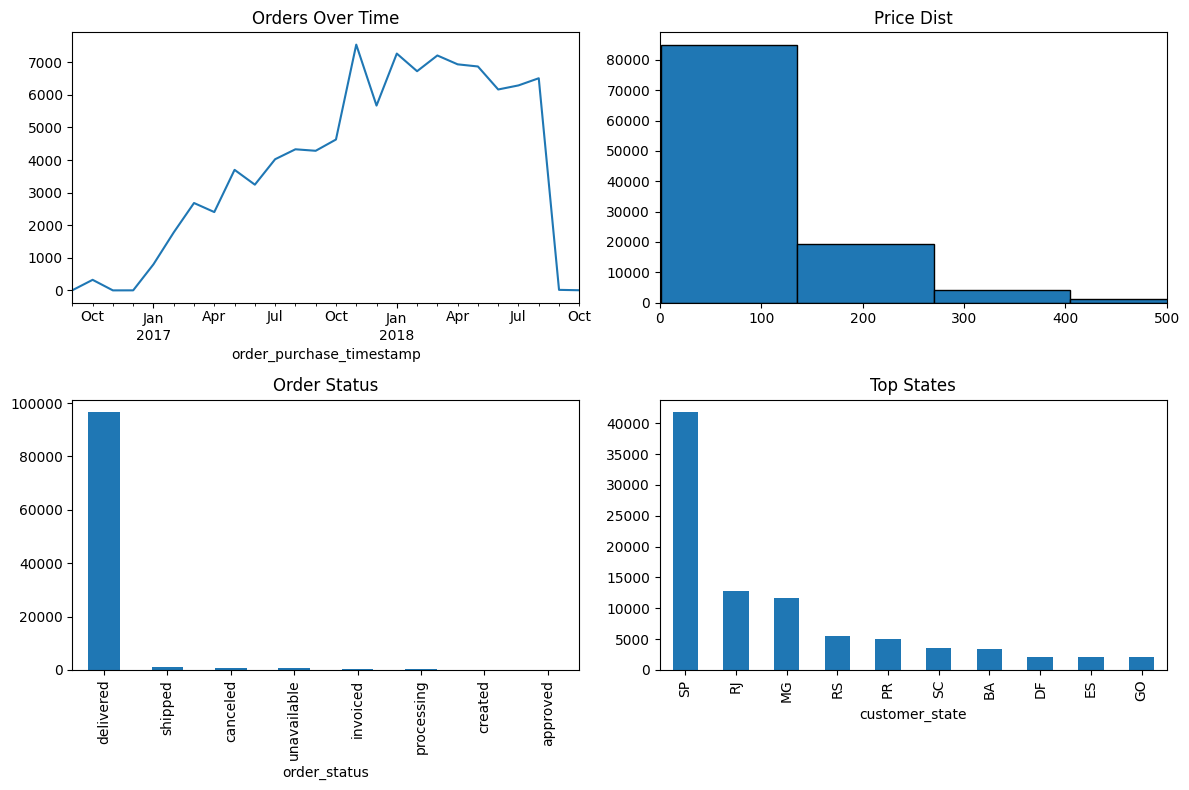

In [25]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
orders.set_index('order_purchase_timestamp').resample('M')['order_id'].count().plot(ax=axes[0,0], title='Orders Over Time')
axes[0,1].hist(order_items['price'], bins=50, edgecolor='k'); axes[0,1].set_xlim(0,500); axes[0,1].set_title('Price Dist')
orders['order_status'].value_counts().plot(kind='bar', ax=axes[1,0], title='Order Status')
customers['customer_state'].value_counts().head(10).plot(kind='bar', ax=axes[1,1], title='Top States')
plt.tight_layout(); plt.show()

## 3. Data Aggregation & Feature Engineering

a. ANALYZE DATA DISTRIBUTION BY MONTH

In [26]:
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])

print(f"   Orders loaded: {len(orders):,}")

print("\n analyzing Order Volume by Month...")

orders['year_month'] = orders['order_purchase_timestamp'].dt.to_period('M')
monthly_orders = orders.groupby('year_month').size()

print("\n   Monthly Order Volume:")
print("   " + "-"*40)
for period in monthly_orders.index[-12:]:  # Last 12 months
    count = monthly_orders[period]
    bar = '█' * (count // 500)
    print(f"   {period}: {count:>6,} {bar}")

# Find the "healthy" period (months with > 5000 orders)
healthy_months = monthly_orders[monthly_orders > 5000]
print(f"\n   Healthy months (>5000 orders): {healthy_months.index[0]} to {healthy_months.index[-1]}")


   Orders loaded: 99,441

 analyzing Order Volume by Month...

   Monthly Order Volume:
   ----------------------------------------
   2017-11:  7,544 ███████████████
   2017-12:  5,673 ███████████
   2018-01:  7,269 ██████████████
   2018-02:  6,728 █████████████
   2018-03:  7,211 ██████████████
   2018-04:  6,939 █████████████
   2018-05:  6,873 █████████████
   2018-06:  6,167 ████████████
   2018-07:  6,292 ████████████
   2018-08:  6,512 █████████████
   2018-09:     16 
   2018-10:      4 

   Healthy months (>5000 orders): 2017-11 to 2018-08


b. aggregate and merge training data

In [27]:
print("\nPreparing Enriched Orders...")
# Merge orders with customers
orders_cust = orders.merge(
    customers[['customer_id', 'customer_unique_id', 'customer_state']],
    on='customer_id'
)

# Order values
order_values = order_items.groupby('order_id').agg(
    total_price=('price', 'sum'),
    total_freight=('freight_value', 'sum'),
    num_items=('order_item_id', 'count'),
    num_products=('product_id', 'nunique')
).reset_index()
order_values['total_order_value'] = order_values['total_price'] + order_values['total_freight']

# Payments
payment_agg = payments.groupby('order_id').agg(
    payment_installments=('payment_installments', 'max'),
    payment_type=('payment_type', lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else 'unknown')
).reset_index()

# Reviews
review_agg = reviews.groupby('order_id')['review_score'].mean().reset_index()

# Merge all
orders_enriched = orders_cust.merge(order_values, on='order_id', how='left')
orders_enriched = orders_enriched.merge(payment_agg, on='order_id', how='left')
orders_enriched = orders_enriched.merge(review_agg, on='order_id', how='left')

# Fill missing
orders_enriched['total_order_value'] = orders_enriched['total_order_value'].fillna(0)
orders_enriched['review_score'] = orders_enriched['review_score'].fillna(3.0)
orders_enriched['payment_installments'] = orders_enriched['payment_installments'].fillna(1)

print(f"   Enriched orders: {len(orders_enriched):,}")


Preparing Enriched Orders...
   Enriched orders: 99,441


c. SELECT OPTIMAL TIME WINDOW

In [28]:
# ============================================================
# SECTION 4: SELECT OPTIMAL TIME WINDOW
# ============================================================
print("\nSelecting Optimal Time Window...")

# KEY INSIGHT: Use data up to July 2018 (before the dropoff)
# Cutoff: June 1, 2018 (predict June purchases using history before June)

# This gives us:
# - ~20 months of history for features (Sept 2016 - May 2018)
# - June 2018 as our prediction target (a full, healthy month)

CUTOFF_DATE = pd.Timestamp('2018-06-01')
LABEL_END_DATE = pd.Timestamp('2018-06-30')

print(f"   Selected cutoff: {CUTOFF_DATE.date()}")
print(f"   Prediction window: {CUTOFF_DATE.date()} to {LABEL_END_DATE.date()} (30 days)")

# Filter to only use data up to end of June 2018 (healthy period)
orders_enriched = orders_enriched[orders_enriched['order_purchase_timestamp'] <= LABEL_END_DATE]

# Split
historical = orders_enriched[orders_enriched['order_purchase_timestamp'] < CUTOFF_DATE].copy()
future = orders_enriched[
    (orders_enriched['order_purchase_timestamp'] >= CUTOFF_DATE) &
    (orders_enriched['order_purchase_timestamp'] <= LABEL_END_DATE)
].copy()

print(f"\n   Historical orders: {len(historical):,}")
print(f"   Future orders (June 2018): {len(future):,}")
print(f"   Users in historical: {historical['customer_unique_id'].nunique():,}")
print(f"   Users who purchased in June: {future['customer_unique_id'].nunique():,}")



Selecting Optimal Time Window...
   Selected cutoff: 2018-06-01
   Prediction window: 2018-06-01 to 2018-06-30 (30 days)

   Historical orders: 80,450
   Future orders (June 2018): 6,043
   Users in historical: 77,808
   Users who purchased in June: 6,005


In [29]:
orders_enriched.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,year_month,customer_unique_id,customer_state,total_price,total_freight,num_items,num_products,total_order_value,payment_installments,payment_type,review_score
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017-10,7c396fd4830fd04220f754e42b4e5bff,SP,29.99,8.72,1.0,1.0,38.71,1.0,voucher,4.0
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,2017-11,7c142cf63193a1473d2e66489a9ae977,RN,45.00,27.20,1.0,1.0,72.20,1.0,credit_card,5.0
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,2018-02,72632f0f9dd73dfee390c9b22eb56dd6,SP,19.90,8.72,1.0,1.0,28.62,1.0,credit_card,5.0
5,a4591c265e18cb1dcee52889e2d8acc3,503740e9ca751ccdda7ba28e9ab8f608,delivered,2017-07-09 21:57:05,2017-07-09 22:10:13,2017-07-11 14:58:04,2017-07-26 10:57:55,2017-08-01,2017-07,80bb27c7c16e8f973207a5086ab329e2,PR,147.90,27.36,1.0,1.0,175.26,6.0,credit_card,4.0
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaT,NaT,2017-05-09,2017-04,36edbb3fb164b1f16485364b6fb04c73,RS,49.90,16.05,1.0,1.0,65.95,1.0,credit_card,2.0


d. FEATURE ENGINEERING

In [30]:
print("\n Engineering Features...")

def create_user_features(orders_df, reference_date):
    """Create RFM + behavioral features at user level."""

    delivered = orders_df[orders_df['order_status'] == 'delivered'].copy()

    # === RECENCY ===
    user_agg = orders_df.groupby('customer_unique_id').agg(
        first_order=('order_purchase_timestamp', 'min'),
        last_order=('order_purchase_timestamp', 'max'),
        total_orders=('order_id', 'count')
    )

    user_agg['days_since_last'] = (reference_date - user_agg['last_order']).dt.days
    user_agg['days_since_first'] = (reference_date - user_agg['first_order']).dt.days
    user_agg['tenure_days'] = (user_agg['last_order'] - user_agg['first_order']).dt.days

    # === FREQUENCY ===
    user_agg['orders_per_month'] = user_agg['total_orders'] / np.maximum(user_agg['tenure_days'] / 30, 1)
    user_agg['is_repeat'] = (user_agg['total_orders'] > 1).astype(int)

    # === MONETARY ===
    if len(delivered) > 0:
        monetary = delivered.groupby('customer_unique_id').agg(
            total_spend=('total_order_value', 'sum'),
            avg_order_value=('total_order_value', 'mean'),
            max_order_value=('total_order_value', 'max'),
            total_items=('num_items', 'sum'),
            avg_items=('num_items', 'mean'),
            avg_installments=('payment_installments', 'mean'),
            avg_review=('review_score', 'mean')
        )
    else:
        monetary = pd.DataFrame(index=user_agg.index)
        for col in ['total_spend', 'avg_order_value', 'max_order_value',
                    'total_items', 'avg_items', 'avg_installments', 'avg_review']:
            monetary[col] = 0

    # === BEHAVIORAL ===
    def safe_mode(x):
        m = x.mode()
        return m.iloc[0] if len(m) > 0 else 'unknown'

    payment_pref = orders_df.groupby('customer_unique_id')['payment_type'].agg(safe_mode)
    state = orders_df.sort_values('order_purchase_timestamp').groupby('customer_unique_id')['customer_state'].last()

    # Delivery rate
    status = orders_df.groupby('customer_unique_id')['order_status'].value_counts().unstack(fill_value=0)
    if 'delivered' in status.columns:
        delivery_rate = status['delivered'] / status.sum(axis=1)
    else:
        delivery_rate = pd.Series(1.0, index=user_agg.index)

    # === COMBINE ===
    features = user_agg.drop(columns=['first_order', 'last_order'])
    features = features.join(monetary, how='left')
    features['payment_pref'] = payment_pref
    features['customer_state'] = state
    features['delivery_rate'] = delivery_rate

    # Fill NaN
    numeric_cols = features.select_dtypes(include=[np.number]).columns
    features[numeric_cols] = features[numeric_cols].fillna(0)
    features['payment_pref'] = features['payment_pref'].fillna('unknown')
    features['customer_state'] = features['customer_state'].fillna('unknown')

    return features.reset_index()

user_features = create_user_features(historical, CUTOFF_DATE)
print(f"   Users with features: {len(user_features):,}")


 Engineering Features...
   Users with features: 77,808


e. create target variables

In [31]:

# Who purchased in June 2018?
june_purchasers = future.groupby('customer_unique_id').agg(
    future_orders=('order_id', 'count'),
    future_value=('total_order_value', 'sum')
).reset_index()

print(f"   June 2018 purchasers: {len(june_purchasers):,}")

# Merge with features
master = user_features.merge(june_purchasers, on='customer_unique_id', how='left')

# Target: did they purchase in June?
master['converted'] = master['future_orders'].notna().astype(int)
master['future_orders'] = master['future_orders'].fillna(0)
master['future_value'] = master['future_value'].fillna(0)

print(f"\n   === FINAL DATASET ===")
print(f"   Total users: {len(master):,}")
print(f"   Converters (bought in June): {master['converted'].sum():,}")
print(f"   Conversion rate: {master['converted'].mean()*100:.2f}%")

# Validate
assert master['converted'].sum() > 100, f"Too few converters: {master['converted'].sum()}"
print(f"   ✓ Validation passed: {master['converted'].sum():,} converters")


   June 2018 purchasers: 6,005

   === FINAL DATASET ===
   Total users: 77,808
   Converters (bought in June): 184
   Conversion rate: 0.24%
   ✓ Validation passed: 184 converters


f. prepare for modelling

In [32]:
print("\nPreparing for Modeling...")

# Encode categoricals
le_pay = LabelEncoder()
le_state = LabelEncoder()
master['payment_enc'] = le_pay.fit_transform(master['payment_pref'].astype(str))
master['state_enc'] = le_state.fit_transform(master['customer_state'].astype(str))

feature_cols = [
    'days_since_last', 'days_since_first', 'tenure_days', 'total_orders',
    'orders_per_month', 'is_repeat', 'total_spend', 'avg_order_value',
    'max_order_value', 'total_items', 'avg_items', 'avg_installments',
    'avg_review', 'delivery_rate', 'payment_enc', 'state_enc'
]

master[feature_cols] = master[feature_cols].replace([np.inf, -np.inf], 0).fillna(0)

# Split
X = master[feature_cols].values
y_cls = master['converted'].values
y_reg = master['future_value'].values

X_train, X_test, y_train_c, y_test_c, y_train_r, y_test_r = train_test_split(
    X, y_cls, y_reg, test_size=0.2, random_state=42, stratify=y_cls
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"   Train: {len(X_train):,} ({y_train_c.sum():,} converters, {y_train_c.mean()*100:.2f}%)")
print(f"   Test: {len(X_test):,} ({y_test_c.sum():,} converters, {y_test_c.mean()*100:.2f}%)")



Preparing for Modeling...
   Train: 62,246 (147 converters, 0.24%)
   Test: 15,562 (37 converters, 0.24%)


# 4. MODEL TRAINING

In [33]:
print("\n[8/9] Training Models...")

# Class weight
pos_weight = (y_train_c == 0).sum() / max((y_train_c == 1).sum(), 1)
print(f"   Class ratio: {pos_weight:.1f}:1 (negative:positive)")

# --- CLASSIFIERS ---
print("\n   Training classifiers...")

classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=200, max_depth=12,
                                            class_weight='balanced', random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=150, max_depth=5, random_state=42)
}


[8/9] Training Models...
   Class ratio: 422.4:1 (negative:positive)

   Training classifiers...


In [34]:
cls_results = {}
for name, clf in classifiers.items():
    if 'Logistic' in name:
        clf.fit(X_train_scaled, y_train_c)
        proba = clf.predict_proba(X_test_scaled)[:, 1]
    else:
        clf.fit(X_train, y_train_c)
        proba = clf.predict_proba(X_test)[:, 1]

    auc = roc_auc_score(y_test_c, proba)
    ap = average_precision_score(y_test_c, proba)
    cls_results[name] = {'AUC': auc, 'AP': ap, 'model': clf, 'proba': proba}
    print(f"   {name}: AUC={auc:.4f}, AP={ap:.4f}")

best_cls_name = max(cls_results, key=lambda x: cls_results[x]['AUC'])
best_clf = cls_results[best_cls_name]['model']
best_proba = cls_results[best_cls_name]['proba']

   Logistic Regression: AUC=0.7114, AP=0.0132
   Random Forest: AUC=0.5951, AP=0.0042
   Gradient Boosting: AUC=0.5424, AP=0.0042


In [35]:
# Try SMOTE
print("\n   Trying SMOTE...")
try:
    from imblearn.over_sampling import SMOTE
    smote = SMOTE(random_state=42)
    X_smote, y_smote = smote.fit_resample(X_train, y_train_c)

    rf_smote = RandomForestClassifier(n_estimators=200, max_depth=12, random_state=42, n_jobs=-1)
    rf_smote.fit(X_smote, y_smote)
    proba_smote = rf_smote.predict_proba(X_test)[:, 1]

    auc_smote = roc_auc_score(y_test_c, proba_smote)
    ap_smote = average_precision_score(y_test_c, proba_smote)
    print(f"   RF+SMOTE: AUC={auc_smote:.4f}, AP={ap_smote:.4f}")

    cls_results['RF+SMOTE'] = {'AUC': auc_smote, 'AP': ap_smote, 'model': rf_smote, 'proba': proba_smote}

    if auc_smote > cls_results[best_cls_name]['AUC']:
        best_cls_name = 'RF+SMOTE'
        best_clf = rf_smote
        best_proba = proba_smote
except ImportError:
    print("   (imbalanced-learn not installed)")

print(f"\n   ✓ Best classifier: {best_cls_name} (AUC={cls_results[best_cls_name]['AUC']:.4f})")

# --- REGRESSOR ---
print("\n   Training regressor on converters...")

conv_idx_train = y_train_c == 1
conv_idx_test = y_test_c == 1
X_train_conv = X_train[conv_idx_train]
y_train_conv = y_train_r[conv_idx_train]
X_test_conv = X_test[conv_idx_test]
y_test_conv = y_test_r[conv_idx_test]

scaler_reg = StandardScaler()
X_train_conv_s = scaler_reg.fit_transform(X_train_conv)
X_test_conv_s = scaler_reg.transform(X_test_conv)

regressors = {
    'Ridge': Ridge(alpha=1.0),
    'RF Regressor': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1),
    'GB Regressor': GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)
}

reg_results = {}
for name, reg in regressors.items():
    if 'Ridge' in name:
        reg.fit(X_train_conv_s, y_train_conv)
        pred = np.maximum(reg.predict(X_test_conv_s), 0)
    else:
        reg.fit(X_train_conv, y_train_conv)
        pred = np.maximum(reg.predict(X_test_conv), 0)

    rmse = np.sqrt(mean_squared_error(y_test_conv, pred))
    mae = mean_absolute_error(y_test_conv, pred)
    r2 = r2_score(y_test_conv, pred)
    reg_results[name] = {'RMSE': rmse, 'MAE': mae, 'R2': r2, 'model': reg}
    print(f"   {name}: RMSE=${rmse:.2f}, MAE=${mae:.2f}, R²={r2:.4f}")

best_reg_name = min(reg_results, key=lambda x: reg_results[x]['RMSE'])
best_reg = reg_results[best_reg_name]['model']
print(f"\n   ✓ Best regressor: {best_reg_name}")


   Trying SMOTE...
   RF+SMOTE: AUC=0.5763, AP=0.0038

   ✓ Best classifier: Logistic Regression (AUC=0.7114)

   Training regressor on converters...
   Ridge: RMSE=$89.63, MAE=$74.78, R²=-0.4042
   RF Regressor: RMSE=$108.10, MAE=$78.20, R²=-1.0430
   GB Regressor: RMSE=$93.31, MAE=$71.89, R²=-0.5220

   ✓ Best regressor: Ridge


# 5. EVALUATION


[9/9] Generating Final Scores...

FINAL RESULTS

📊 CLASSIFICATION: Logistic Regression
   ROC-AUC: 0.7114
   Avg Precision: 0.0132

💰 REGRESSION: Ridge
   RMSE: $89.63
   MAE: $74.78
   R²: -0.4042

📈 BUSINESS METRICS:
   Users scored: 77,808
   Baseline conversion: 0.24%
   Top decile conversion: 0.68%
   Top decile lift: 2.88x
   Top 20% captures: 45.7% of conversions

📋 LIFT TABLE:
   Decile | Users | Conv | Rate   | Lift
   ---------------------------------------------
        9 |  7781 |   53 |  0.68% | 2.88x
        8 |  7781 |   31 |  0.40% | 1.68x
        7 |  7781 |   19 |  0.24% | 1.03x
        6 |  7780 |   18 |  0.23% | 0.98x
        5 |  7781 |   15 |  0.19% | 0.82x
        4 |  7781 |   13 |  0.17% | 0.71x
        3 |  7780 |   12 |  0.15% | 0.65x
        2 |  7781 |    9 |  0.12% | 0.49x
        1 |  7781 |    7 |  0.09% | 0.38x
        0 |  7781 |    7 |  0.09% | 0.38x

✓ Saved 'user_propensity_scores.csv'
✓ Saved 'model_plots.png'


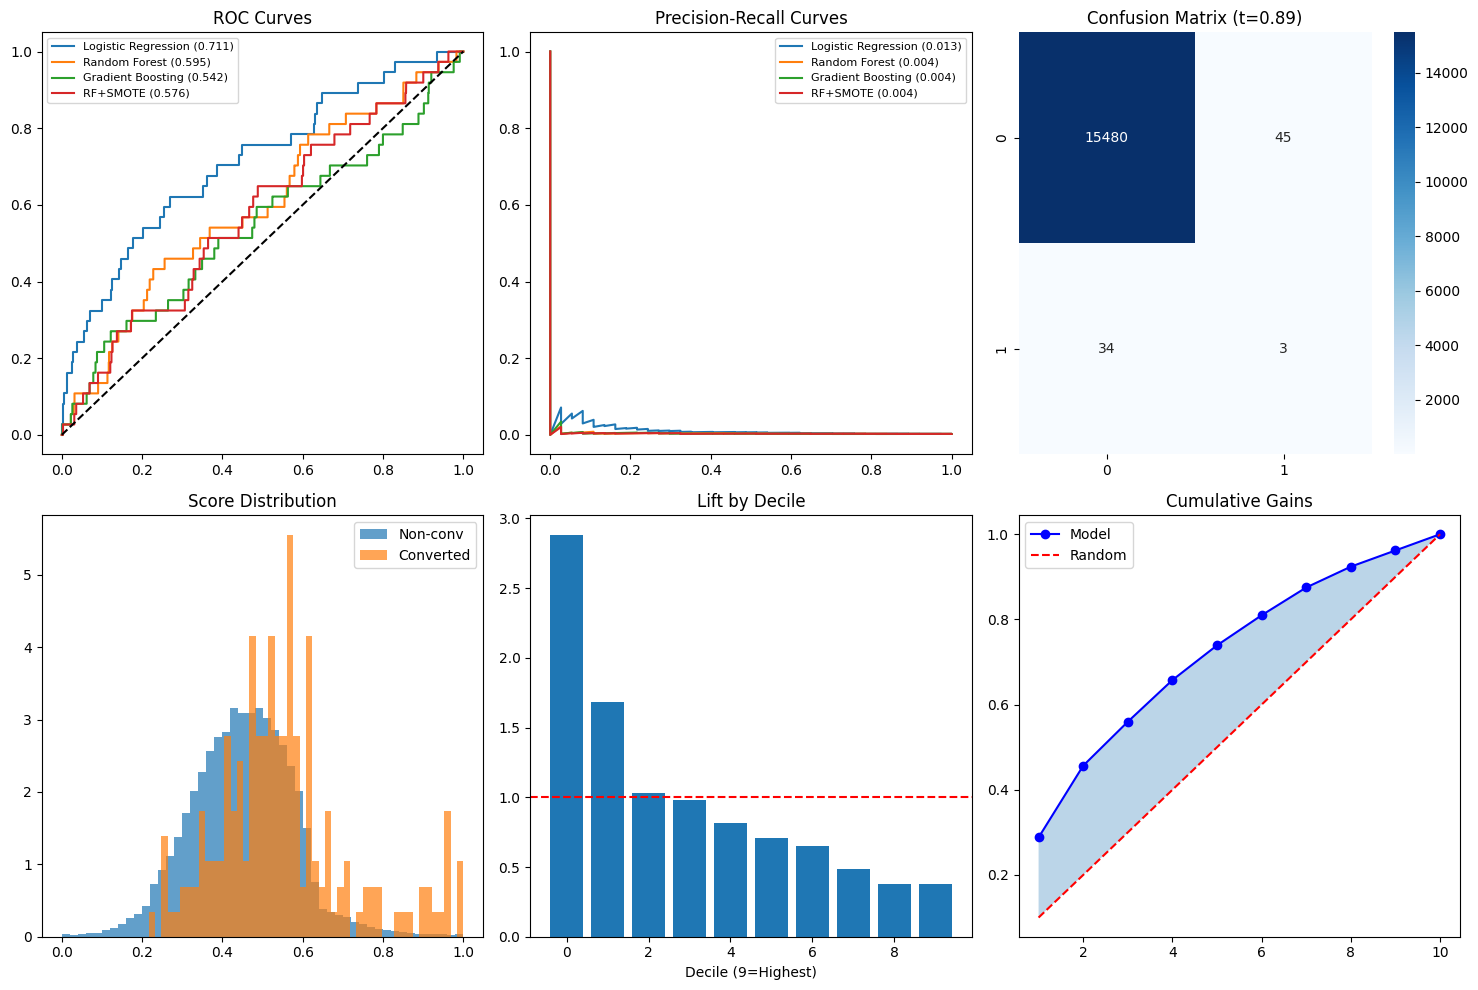


✅ COMPLETE


In [36]:
print("\n[9/9] Generating Final Scores...")

X_all = master[feature_cols].values

# Propensity
if 'Logistic' in best_cls_name:
    propensity = best_clf.predict_proba(scaler.transform(X_all))[:, 1]
else:
    propensity = best_clf.predict_proba(X_all)[:, 1]

# Value prediction
if 'Ridge' in best_reg_name:
    pred_value = np.maximum(best_reg.predict(scaler_reg.transform(X_all)), 0)
else:
    pred_value = np.maximum(best_reg.predict(X_all), 0)

expected_value = propensity * pred_value

# Final output
final = pd.DataFrame({
    'customer_unique_id': master['customer_unique_id'],
    'propensity_score': propensity,
    'predicted_order_value': pred_value,
    'expected_value': expected_value,
    'actual_converted': master['converted'],
    'actual_value': master['future_value']
}).sort_values('propensity_score', ascending=False)

# --- LIFT ANALYSIS ---
final['decile'] = pd.qcut(final['propensity_score'].rank(method='first'), 10, labels=False)
lift = final.groupby('decile').agg(
    users=('propensity_score', 'count'),
    conversions=('actual_converted', 'sum'),
    conv_rate=('actual_converted', 'mean'),
    value=('actual_value', 'sum')
)
baseline = final['actual_converted'].mean()
lift['lift'] = lift['conv_rate'] / baseline
lift = lift.sort_index(ascending=False)

cum_gains = np.cumsum(lift['conversions'].values) / lift['conversions'].sum()

# --- PRINT RESULTS ---
print("\n" + "="*70)
print("FINAL RESULTS")
print("="*70)

print(f"\n📊 CLASSIFICATION: {best_cls_name}")
print(f"   ROC-AUC: {cls_results[best_cls_name]['AUC']:.4f}")
print(f"   Avg Precision: {cls_results[best_cls_name]['AP']:.4f}")

print(f"\n💰 REGRESSION: {best_reg_name}")
print(f"   RMSE: ${reg_results[best_reg_name]['RMSE']:.2f}")
print(f"   MAE: ${reg_results[best_reg_name]['MAE']:.2f}")
print(f"   R²: {reg_results[best_reg_name]['R2']:.4f}")

print(f"\n📈 BUSINESS METRICS:")
print(f"   Users scored: {len(final):,}")
print(f"   Baseline conversion: {baseline*100:.2f}%")
print(f"   Top decile conversion: {lift.iloc[0]['conv_rate']*100:.2f}%")
print(f"   Top decile lift: {lift.iloc[0]['lift']:.2f}x")
print(f"   Top 20% captures: {cum_gains[1]*100:.1f}% of conversions")

print("\n📋 LIFT TABLE:")
print("   Decile | Users | Conv | Rate   | Lift")
print("   " + "-"*45)
for idx in lift.index:
    r = lift.loc[idx]
    print(f"   {idx:>6} | {r['users']:>5.0f} | {r['conversions']:>4.0f} | {r['conv_rate']*100:>5.2f}% | {r['lift']:.2f}x")

# --- SAVE ---
final.to_csv('user_propensity_scores.csv', index=False)
print("\n✓ Saved 'user_propensity_scores.csv'")

# Feature importance
if hasattr(best_clf, 'feature_importances_'):
    imp = pd.DataFrame({'feature': feature_cols, 'importance': best_clf.feature_importances_})
    imp = imp.sort_values('importance', ascending=False)
    print("\n🔍 TOP FEATURES:")
    for _, row in imp.head(5).iterrows():
        print(f"   {row['feature']}: {row['importance']:.4f}")

# --- PLOTS ---
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# ROC
for name, res in cls_results.items():
    fpr, tpr, _ = roc_curve(y_test_c, res['proba'])
    axes[0,0].plot(fpr, tpr, label=f"{name} ({res['AUC']:.3f})")
axes[0,0].plot([0,1],[0,1],'k--')
axes[0,0].set_title('ROC Curves')
axes[0,0].legend(fontsize=8)

# PR
for name, res in cls_results.items():
    prec, rec, _ = precision_recall_curve(y_test_c, res['proba'])
    axes[0,1].plot(rec, prec, label=f"{name} ({res['AP']:.3f})")
axes[0,1].set_title('Precision-Recall Curves')
axes[0,1].legend(fontsize=8)

# Confusion Matrix
prec, rec, thresh = precision_recall_curve(y_test_c, best_proba)
f1 = 2*prec*rec/(prec+rec+1e-10)
opt_t = thresh[np.argmax(f1)] if len(thresh) > 0 else 0.5
cm = confusion_matrix(y_test_c, (best_proba >= opt_t).astype(int))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,2])
axes[0,2].set_title(f'Confusion Matrix (t={opt_t:.2f})')

# Score distribution
axes[1,0].hist(final[final['actual_converted']==0]['propensity_score'], bins=50, alpha=0.7, label='Non-conv', density=True)
axes[1,0].hist(final[final['actual_converted']==1]['propensity_score'], bins=50, alpha=0.7, label='Converted', density=True)
axes[1,0].set_title('Score Distribution')
axes[1,0].legend()

# Lift
axes[1,1].bar(range(10), lift['lift'].values)
axes[1,1].axhline(1, color='r', linestyle='--')
axes[1,1].set_title('Lift by Decile')
axes[1,1].set_xlabel('Decile (9=Highest)')

# Cumulative gains
axes[1,2].plot(range(1,11), cum_gains, 'b-o', label='Model')
axes[1,2].plot(range(1,11), np.linspace(0.1,1,10), 'r--', label='Random')
axes[1,2].fill_between(range(1,11), cum_gains, np.linspace(0.1,1,10), alpha=0.3)
axes[1,2].set_title('Cumulative Gains')
axes[1,2].legend()

plt.tight_layout()
plt.savefig('model_plots.png', dpi=150)
print("✓ Saved 'model_plots.png'")
plt.show()

print("\n" + "="*70)
print("✅ COMPLETE")
print("="*70)